# Testing Objective

A comparison between:
1. perfectly balanced dataset
2. balanced based on Q1 of class size
3. all of the data
4. randomly adding in data
5. adding in data by lowest class precision * (main test)





In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np

## Create Train/Valid/Test Datasets + Supplemental Dataset

In [68]:
# read the csv file into a DataFrame
df = pd.read_csv(r'jobboard_reed_uk_primary.csv')
supplemental = pd.read_csv(r'jobboard_reed_uk_secondary.csv')

In [49]:
# first lets stratify the train (+valid) and test data, such that the test data is reflective of the classes we might see
from sklearn.model_selection import train_test_split

train_valid, test = train_test_split(df, test_size=0.2, stratify=df["category"]) 
train, valid = train_test_split(train_valid, test_size=0.25, stratify=train_valid["category"]) 
print("training dataset: ", train.shape[0])
print("validation dataset: ", valid.shape[0])
print("testing dataset: ", test.shape[0])
print("supplemental dataset: ", df_supp.shape[0])

# display class sizes of train_valid split
df_group = train_valid.groupby(['category']).size().reset_index(name='labels').sort_values(by=['labels'], ascending=False)
df_group.head()

training dataset:  6000
validation dataset:  2000
testing dataset:  2000
supplemental dataset:  40000


,category,labels
34,social care jobs,337
9,education jobs,334
20,it jobs,318
0,accountancy jobs,311
18,health jobs,309


## Creating the classification report

In [52]:
from sklearn.metrics import hamming_loss, classification_report, accuracy_score
#list_actual = df.code
#list_predicted = df.pred

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:

def expanded_classification_report(list_actual, list_predicted, trainingdata):

    # standard classification report
    report = classification_report(list_actual, list_predicted, output_dict=True)
    df_class = pd.DataFrame(report).transpose()
    df_class["class"] = df_class.index
    df_class = df_class.reset_index(drop=True)

    # create dataframe out of actual, predicted classes to find confused class
    df_lists = pd.DataFrame({'code': list_actual, 'pred': list_predicted})
    
    # find confused class
    def confused_class(code):    
        df_class = df_lists[df_lists["code"].astype(str) == str(code)]
        df_group = df_class.groupby(['pred']).size().reset_index(name='labels')
        df_group = df_group[df_group['pred'] != str(code)]
        df_group = df_group.sort_values(by=['labels'], ascending=False)
        most_confused = df_group.iloc[1,0]
        return most_confused

    df_class.drop(df_class.tail(3).index,inplace=True) # drop last 3 rows from dataframe b/c micro/macro/weighted averages
    df_class['confused_class'] = df_class.apply(lambda row: confused_class(row["class"]), axis=1)

    # count all labels in training dataset, !* change groupby to args category
    df_labels = trainingdata.groupby(['category']).size().reset_index(name='labels')
    df_labels = df_labels.rename(columns={'category': 'class'})

    def train_class_size(value):
        df_temp = df_labels[df_labels['class'].astype(str) == str(value)]
        count = df_temp.iloc[0,1]
        return count

    df_class['class_traindata'] = df_class.apply(lambda row: train_class_size(row["class"]), axis=1)
    df_class['confused_class_traindata'] = df_class.apply(lambda row: train_class_size(row["confused_class"]), axis=1)

    # select classes to add training data to
    df_class = df_class.sort_values(by=['precision'], ascending=True)
    df_class_selected = df_class.iloc[0:supplement_class_number,:]

    return df_class_selected


#df_class_selected = expanded_classification_report(list_actual, list_predicted, df)

#df_class_selected.head()

## Create a pipeline to add new data

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Generic Random Sample without Replacement

In [85]:
n_iterations = 20
step_value = 88

df_primary = train.copy()
df_supplemental = supplemental.sample(frac=1).reset_index(drop=True)
df_validation = valid.copy()

log_accuracy = []
log_records = []
log_weighted_f1 = []
log_weighted_precision = []
log_weighted_recall = []
log_iteration = list(range(0, n_iterations))

for i in range(n_iterations):

    # create the training datasets
    def sample_without_replacement(dataframe):
        sample = dataframe[0:step_value]
        replace = dataframe.drop(dataframe.index[0:step_value])
        return replace, sample
    
    # create a definition to be able to write over the original training and supplemental datasets
    def run_iteration(primarydata, supplementaldata):
        
        # create two datasets, one to add to the primary and one to return at the end
        df_supplemental, sample = sample_without_replacement(supplementaldata)

        # add new data into training dataset
        df_primary = primarydata.append(sample)

        # map each word in our training narratives to a vector position
        vectorizer = CountVectorizer()
        vectorizer.fit(df_primary['job_title'])

        # convert each training narrative to its vector representation and stack them into a matrix
        x_training = vectorizer.transform(df_primary['job_title'])
        x_validation = vectorizer.transform(df_validation['job_title'])

        # y_training contains the codes associated with our training narratives
        y_training = df_primary['category']
        y_validation = df_validation['category']

        # create model, predict
        clf = LogisticRegression(C=1.0)
        clf.fit(x_training, y_training)
        y_validation_pred = clf.predict(x_validation)

        # generate parameters
        accuracy = accuracy_score(y_validation, y_validation_pred)
        records = df_primary.shape[0]
        
        w_f1 = f1_score(y_validation, y_validation_pred, average = "weighted")
        w_precision = precision_score(y_validation, y_validation_pred, average = "weighted")
        w_recall = recall_score(y_validation, y_validation_pred, average = "weighted")    
        
        
        print("Iteration:", i+1, ", size of primary dataset: ",df_primary.shape[0],", supplemental: ", df_supplemental.shape[0])
        
        return df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall
    
    df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall = run_iteration(df_primary, df_supplemental)
    
    log_accuracy.append(accuracy)
    log_records.append(records)
    log_weighted_f1.append(w_f1)
    log_weighted_precision.append(w_precision)
    log_weighted_recall.append(w_recall)



# create a dataframe from the logged lists
df_iterations_random = pd.DataFrame(
    {'iteration': log_iteration,
     'records': log_records,
      'weighted_f1': log_weighted_f1,
      'weighted_precision': log_weighted_precision,
      'weighted_recall': log_weighted_recall   
     })
df_iterations_random.head()


Iteration: 1 , size of primary dataset:  6088 , supplemental:  39912
Iteration: 2 , size of primary dataset:  6176 , supplemental:  39824
Iteration: 3 , size of primary dataset:  6264 , supplemental:  39736
Iteration: 4 , size of primary dataset:  6352 , supplemental:  39648
Iteration: 5 , size of primary dataset:  6440 , supplemental:  39560
Iteration: 6 , size of primary dataset:  6528 , supplemental:  39472
Iteration: 7 , size of primary dataset:  6616 , supplemental:  39384
Iteration: 8 , size of primary dataset:  6704 , supplemental:  39296
Iteration: 9 , size of primary dataset:  6792 , supplemental:  39208
Iteration: 10 , size of primary dataset:  6880 , supplemental:  39120
Iteration: 11 , size of primary dataset:  6968 , supplemental:  39032
Iteration: 12 , size of primary dataset:  7056 , supplemental:  38944
Iteration: 13 , size of primary dataset:  7144 , supplemental:  38856
Iteration: 14 , size of primary dataset:  7232 , supplemental:  38768
Iteration: 15 , size of prima

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,0,6088,0.635958,0.647068,0.6400
1,1,6176,0.636117,0.647669,0.6400
2,2,6264,0.637517,0.649177,0.6420
3,3,6352,0.639319,0.651575,0.6435
4,4,6440,0.639677,0.650139,0.6440


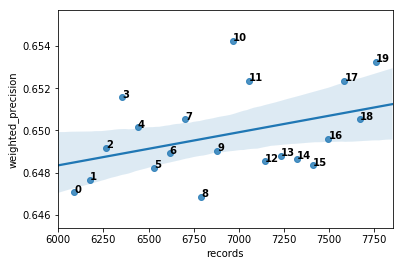

In [88]:
import matplotlib.pylab as plt
import seaborn as sns

pl = sns.regplot(x=df_iterations_random["records"], y=df_iterations_random["weighted_precision"])

# add annotations one by one with a loop
for line in range(0,df_iterations_random.shape[0]):
     pl.text(df_iterations_random["records"][line]+0.4, df_iterations_random["weighted_precision"][line], 
             df_iterations_random["iteration"][line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')


## Sample based on class precision (without replacement)

### Expanded Classification Report

In [80]:

def expanded_classification_report(list_actual, list_predicted, trainingdata):

    # standard classification report
    report = classification_report(list_actual, list_predicted, output_dict=True)
    df_class = pd.DataFrame(report).transpose()
    df_class["class"] = df_class.index
    df_class = df_class.reset_index(drop=True)

    # create dataframe out of actual, predicted classes to find confused class
    df_lists = pd.DataFrame({'code': list_actual, 'pred': list_predicted})
    
    # find confused class
    def confused_class(code):    
        df_class = df_lists[df_lists['code'].astype(str) == str(code)]
        df_group = df_class.groupby(['pred']).size().reset_index(name='labels')
        df_group = df_group[df_group['pred'] != str(code)]
        df_group = df_group.sort_values(by=['labels'], ascending=False)
        if df_group.shape[0] == 1:
            return code
        else:
            most_confused = df_group.iloc[1,0]
            return most_confused

    df_class.drop(df_class.tail(3).index,inplace=True) # drop last 3 rows from dataframe b/c micro/macro/weighted averages
    df_class['confused_class'] = df_class.apply(lambda row: confused_class(row["class"]), axis=1)

    # count all labels in training dataset, !* change groupby to args category
    df_labels = trainingdata.groupby(['category']).size().reset_index(name='labels')
    df_labels = df_labels.rename(columns={'category': 'class'})

    def train_class_size(value):
        df_temp = df_labels[df_labels['class'].astype(str) == str(value)]
        count = df_temp.iloc[0,1]
        return count

    df_class['class_traindata'] = df_class.apply(lambda row: train_class_size(row["class"]), axis=1)
    df_class['confused_class_traindata'] = df_class.apply(lambda row: train_class_size(row["confused_class"]), axis=1)

    # select classes to add training data to
    df_class = df_class.sort_values(by=['precision'], ascending=True)
    df_class_selected = df_class.iloc[0:supplement_class_number,:]

    return df_class_selected

#df_class_selected = expanded_classification_report(list_actual, list_predicted, df)

### Function to replace existing datasets for iterations

In [81]:

# create a definition to be able to write over the original training and supplemental datasets
def supplement_trainingdata(classes_selected, primarydata, supplementaldata):

    # determine which class to add to
    column_names = list(supplementaldata.columns)  
    add_labels = []
    
    for index,row in classes_selected.iterrows():
        
        # determine basic vales to compare against class and its confused class
        difference = abs(row["class_traindata"] - row["confused_class_traindata"])
        primary_class = row["class"]
        primary_class_labels = int(row["class_traindata"])

        confused_class = row["confused_class"]
        confused_class_labels = int(row["confused_class_traindata"])

        # if difference is less than a certain value then we need to add more labels to both classes 
        if difference < 10:
            primary_temp = supplementaldata[supplementaldata["category"].astype(str) == str(primary_class)] # find class
            primary_temp = primary_temp.iloc[0:step_value].values.tolist() # take the number of rows according to step value
            add_labels.extend(primary_temp) # append new labels to our add_labels list

            confused_temp = supplementaldata[supplementaldata["category"].astype(str) == str(confused_class)]
            confused_temp = confused_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(confused_temp)

        # if difference is greater than a certain value we only add labels to the minority class
        if difference > 10 and primary_class_labels < confused_class_labels:
            primary_temp = supplementaldata[supplementaldata["category"].astype(str) == str(primary_class)]
            primary_temp = primary_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(primary_temp)

        if difference > 10 and primary_class_labels > confused_class_labels:
            confused_temp = supplementaldata[supplementaldata["category"].astype(str) == str(confused_class)]
            confused_temp = confused_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(confused_temp)

    # create dataframe out of added labels
    df_add_labels = pd.DataFrame(add_labels, columns = column_names)
    
    # remove added labels from supplemental dataset to ensure 
    df_supp_withoutreplacement = df_supplemental.append(df_add_labels)
    df_supp_withoutreplacement.drop_duplicates(keep = False, inplace = True)
    #df_supp_withoutreplacement.reset_index(drop=True) # reset the index to be able to take first rows again

    # add new labels to training data
    training_data = df_primary.copy()
    training_data_new = training_data.append(df_add_labels)

    return training_data_new, df_supp_withoutreplacement


#df_primary, df_supplemental =  supplement_trainingdata(df_class_selected, df_primary, df_supplemental)


### Run Iterations

In [82]:
df_primary = train.copy()
df_supplemental = supplemental.copy()

In [83]:
n_iterations = 30
step_value = 10
supplement_class_number = 5

log_accuracy = []
log_records = []
log_weighted_f1 = []
log_weighted_precision = []
log_weighted_recall = []
log_iteration = list(range(0, n_iterations))

for i in range(n_iterations):

    
    # create a definition to be able to write over the original training and supplemental datasets
    def run_iteration(primarydata, supplementaldata):
        
        # map each word in our training narratives to a vector position
        vectorizer = CountVectorizer()
        vectorizer.fit(primarydata['job_title'])

        # convert each training narrative to its vector representation and stack them into a matrix
        x_training = vectorizer.transform(primarydata['job_title'])
        x_validation = vectorizer.transform(df_validation['job_title'])

        # y_training contains the codes associated with our training narratives
        y_training = primarydata['category']
        y_validation = df_validation['category']

        # create model, predict
        clf = LogisticRegression(C=1.0)
        clf.fit(x_training, y_training)
        y_validation_pred = clf.predict(x_validation)

        # generate parameters
        accuracy = accuracy_score(y_validation, y_validation_pred)
        records = primarydata.shape[0]
        
        w_f1 = f1_score(y_validation, y_validation_pred, average = "weighted")
        w_precision = precision_score(y_validation, y_validation_pred, average = "weighted")
        w_recall = recall_score(y_validation, y_validation_pred, average = "weighted")    
        
        
        ## generate new datasets based on errors of current model
        df_class_selected = expanded_classification_report(y_validation, y_validation_pred, primarydata)
        
        ## supplement training data based on low precision in selected classes
        df_primary, df_supplemental =  supplement_trainingdata(df_class_selected, primarydata, supplementaldata)
        
        # report iterations
        print("Iteration:", i+1, ", size of primary dataset: ",df_primary.shape[0],", supplemental: ", df_supplemental.shape[0])
        
        return df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall
    
    df_primary, df_supplemental, accuracy, records, w_f1, w_precision , w_recall = run_iteration(df_primary, df_supplemental)
    
    log_accuracy.append(accuracy)
    log_records.append(records)
    log_weighted_f1.append(w_f1)
    log_weighted_precision.append(w_precision)
    log_weighted_recall.append(w_recall)

# create a dataframe from the logged lists
df_iterations = pd.DataFrame(
    {'iteration': log_iteration,
     'records': log_records,
      'weighted_f1': log_weighted_f1,
      'weighted_precision': log_weighted_precision,
      'weighted_recall': log_weighted_recall   
     })
df_iterations.head()


Iteration: 1 , size of primary dataset:  6060 , supplemental:  39940
Iteration: 2 , size of primary dataset:  6120 , supplemental:  39880
Iteration: 3 , size of primary dataset:  6180 , supplemental:  39820
Iteration: 4 , size of primary dataset:  6240 , supplemental:  39770
Iteration: 5 , size of primary dataset:  6290 , supplemental:  39720
Iteration: 6 , size of primary dataset:  6340 , supplemental:  39670
Iteration: 7 , size of primary dataset:  6390 , supplemental:  39620
Iteration: 8 , size of primary dataset:  6440 , supplemental:  39580
Iteration: 9 , size of primary dataset:  6480 , supplemental:  39540
Iteration: 10 , size of primary dataset:  6520 , supplemental:  39500
Iteration: 11 , size of primary dataset:  6580 , supplemental:  39440
Iteration: 12 , size of primary dataset:  6640 , supplemental:  39380
Iteration: 13 , size of primary dataset:  6710 , supplemental:  39310
Iteration: 14 , size of primary dataset:  6780 , supplemental:  39240
Iteration: 15 , size of prima

,iteration,records,weighted_f1,weighted_precision,weighted_recall
0,0,6000,0.634825,0.645134,0.6395
1,1,6060,0.635146,0.646367,0.6385
2,2,6120,0.635389,0.647640,0.6380
3,3,6180,0.634885,0.649830,0.6350
4,4,6240,0.634439,0.651335,0.6335


Text(7870.5, 0.6845797721568688, 'Top Value: 0.685')

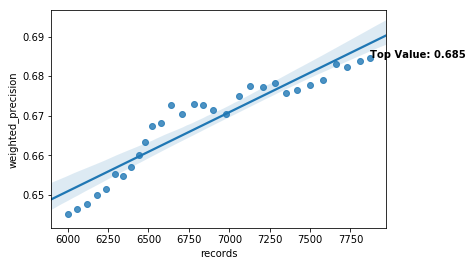

In [109]:
import matplotlib.pylab as plt
import seaborn as sns

pl = sns.regplot(x=df_iterations["records"], y=df_iterations["weighted_precision"])

# add annotations one by one with a loop
#for line in range(0,df_iterations.shape[0]):
#     pl.text(df_iterations["records"][line]+0.4, df_iterations["weighted_precision"][line], df_iterations["iteration"][line], 
#             horizontalalignment='left', size='medium', color='black', weight='semibold')

# add annotation for hightest value
annotation = df_iterations.sort_values(by=['weighted_precision'], ascending=False)
x = annotation.iloc[0,1]
y = annotation.iloc[0,3]

pl.text(x+0.5, y, str("Top Value: "+str(round(y,3))), horizontalalignment='left', size='medium', color='black', weight='semibold')
#sns.plt.show()


In [99]:
print(x)
print(y)
annotation.head()

7870
0.6484754130401791


,iteration,records,weighted_f1,weighted_precision,weighted_recall
29,29,7870,0.648475,0.684580,0.6385
28,28,7810,0.647745,0.683741,0.6380
26,26,7660,0.645762,0.683040,0.6355
27,27,7730,0.646595,0.682403,0.6365
25,25,7580,0.644809,0.679071,0.6345


## Add static amount to minority class based on Q1 amount 

In [110]:
df_supplemental = supplemental.copy()
df_group = df_supplemental.groupby(['category']).size().reset_index(name='labels').sort_values(by=['labels'], ascending=False)
df_group.head()


,category,labels
18,health jobs,1544
23,logistics jobs,1514
31,sales jobs,1497
20,it jobs,1493
7,construction property jobs,1490


## Testing

In [257]:
df_primary = df_trainingdata.copy()
df_supplemental = df_secondary.copy()

print("primary start: ", df_primary.shape[0])
print("supplemental start: ",df_supplemental.shape[0])

primary start:  7000
supplemental start:  1160


In [263]:
def run_iteration(primarydata, supplementaldata):
        
        # map each word in our training narratives to a vector position
        vectorizer = CountVectorizer()
        vectorizer.fit(primarydata['job_title'])

        # convert each training narrative to its vector representation and stack them into a matrix
        x_training = vectorizer.transform(primarydata['job_title'])
        x_validation = vectorizer.transform(df_validation['job_title'])

        # y_training contains the codes associated with our training narratives
        y_training = primarydata['category']
        y_validation = df_validation['category']

        # create model, predict
        clf = LogisticRegression(C=1.0)
        clf.fit(x_training, y_training)
        y_validation_pred = clf.predict(x_validation)

        # generate parameters
        accuracy = accuracy_score(y_validation, y_validation_pred)
        records = primarydata.shape[0]
        
        w_f1 = f1_score(y_validation, y_validation_pred, average = "weighted")
        w_precision = precision_score(y_validation, y_validation_pred, average = "weighted")
        w_recall = recall_score(y_validation, y_validation_pred, average = "weighted")    
        
        
        ## generate new datasets based on errors of current model
        df_class_selected = expanded_classification_report(y_validation, y_validation_pred, primarydata)
        
        ## supplement training data based on low precision in selected classes
        df_primary, df_supplemental =  supplement_trainingdata(df_class_selected, primarydata, supplementaldata)
        
        # report iterations
        print("Iteration:", i+1, ", size of primary dataset: ",df_primary.shape[0],", supplemental: ", df_supplemental.shape[0])
        
        return df_class_selected

In [265]:
# create a definition to be able to write over the original training and supplemental datasets
def supplement_trainingdata(classes_selected, primarydata, supplementaldata):

    # determine which class to add to
    column_names = list(supplementaldata.columns)  
    add_labels = []
    
    for index, row in classes_selected.iterrows():
        
        # determine basic vales to compare against class and its confused class
        difference = abs(row["class_traindata"] - row["confused_class_traindata"])
        primary_class = row["class"]
        primary_class_labels = int(row["class_traindata"])

        confused_class = row["confused_class"]
        confused_class_labels = int(row["confused_class_traindata"])

        # if difference is less than a certain value then we need to add more labels to both classes 
        if difference < 10:
            primary_temp = supplementaldata[supplementaldata["category"].astype(str) == str(primary_class)] # find class
            primary_temp = primary_temp.iloc[0:step_value].values.tolist() # take the number of rows according to step value
            add_labels.extend(primary_temp) # append new labels to our add_labels list

            confused_temp = supplementaldata[supplementaldata["category"].astype(str) == str(confused_class)]
            confused_temp = confused_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(confused_temp)

        # if difference is greater than a certain value we only add labels to the minority class
        if difference > 10 and primary_class_labels < confused_class_labels:
            primary_temp = supplementaldata[supplementaldata["category"].astype(str) == str(primary_class)]
            primary_temp = primary_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(primary_temp)

        if difference > 10 and primary_class_labels > confused_class_labels:
            confused_temp = supplementaldata[supplementaldata["category"].astype(str) == str(confused_class)]
            confused_temp = confused_temp.iloc[0:step_value].values.tolist()
            add_labels.extend(confused_temp)

    # create dataframe out of added labels
    df_add_labels = pd.DataFrame(add_labels, columns = column_names)
    
    # remove added labels from supplemental dataset to ensure 
    df_supp_withoutreplacement = df_supplemental.append(df_add_labels)
    df_supp_withoutreplacement.drop_duplicates(keep = False, inplace = True)
    #df_supp_withoutreplacement.reset_index(drop=True) # reset the index to be able to take first rows again

    # add new labels to training data
    training_data = df_primary.copy()
    training_data_new = training_data.append(df_add_labels)

    return training_data_new, df_supp_withoutreplacement

df_class_selected = run_iteration(df_primary, df_supplemental)
df_primary, df_supplemental =  supplement_trainingdata(df_class_selected, df_primary, df_supplemental)

print(df_primary.shape[0])
print(df_supplemental.shape[0])

Iteration: 10 , size of primary dataset:  7055 , supplemental:  1120
7055
1120


In [266]:
df_class_selected.head()

,f1-score,precision,recall,support,class,confused_class,class_traindata,confused_class_traindata
35,0.428571,0.363636,0.521739,23.0,strategy consultancy jobs,fmcg jobs,120,134
4,0.413793,0.400000,0.428571,28.0,banking jobs,strategy consultancy jobs,151,120
11,0.495726,0.446154,0.557692,52.0,engineering jobs,construction property jobs,266,258
13,0.485294,0.458333,0.515625,64.0,factory jobs,admin secretarial pa jobs,246,272
27,0.384615,0.468750,0.326087,46.0,other jobs,factory jobs,202,246
